# Food-101 Dataset Preprocessing

This notebook handles the preprocessing of the Food-101 dataset, including:
1. Image resizing and standardization
2. Data augmentation
3. Train/validation/test split
4. Data pipeline setup

In [66]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import random
from sklearn.model_selection import train_test_split

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [67]:
# Define paths and constants
DATASET_PATH = Path('../food-101')
IMAGES_PATH = DATASET_PATH / 'images'
OUTPUT_PATH = Path('../processed_data')

# Create output directories
OUTPUT_PATH.mkdir(exist_ok=True)
(OUTPUT_PATH / 'train').mkdir(exist_ok=True)
(OUTPUT_PATH / 'val').mkdir(exist_ok=True)
(OUTPUT_PATH / 'test').mkdir(exist_ok=True)

# Model parameters
IMG_SIZE = 224  # Standard size for many CNN architectures
BATCH_SIZE = 32
NUM_CLASSES = 101
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.2
  

In [68]:
# Define data augmentation pipeline
def get_augmentation_pipeline(is_training=True):
    if is_training:
        return A.Compose([
            A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.8, 1.0)),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.RandomRotate90(p=0.2),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0
            ),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Resize(height=IMG_SIZE, width=IMG_SIZE),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0
            ),
            ToTensorV2(),
        ])

In [69]:
# Function to process and save images
def process_and_save_image(image_path, output_path, transform):
    # Read image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Apply transformations
    transformed = transform(image=image)
    processed_image = transformed['image']
    
    # Denormalize the image
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    denormalized = processed_image * std + mean
    denormalized = denormalized.clamp(0, 1)  # Ensure values are between 0 and 1
    
    # Save processed image
    output_path.parent.mkdir(parents=True, exist_ok=True)
    plt.imsave(output_path, denormalized.permute(1, 2, 0).numpy())

# Function to create dataset splits
def create_dataset_splits():
    all_images = []
    all_labels = []
    
    # Collect all images and labels
    for class_idx, class_name in enumerate(sorted(IMAGES_PATH.iterdir())):
        if class_name.is_dir():
            for img_path in class_name.glob('*.jpg'):
                all_images.append(img_path)
                all_labels.append(class_idx)
    
    # Create train/val/test splits
    train_images, temp_images, train_labels, temp_labels = train_test_split(
        all_images, all_labels, test_size=TEST_SPLIT + VALIDATION_SPLIT, stratify=all_labels
    )
    
    val_images, test_images, val_labels, test_labels = train_test_split(
        temp_images, temp_labels, test_size=TEST_SPLIT/(TEST_SPLIT + VALIDATION_SPLIT), stratify=temp_labels
    )
    
    return {
        'train': list(zip(train_images, train_labels)),
        'val': list(zip(val_images, val_labels)),
        'test': list(zip(test_images, test_labels))
    }
  

In [70]:
# Create and process dataset splits
print("Creating dataset splits...")
dataset_splits = create_dataset_splits()

# Get augmentation pipelines
train_transform = get_augmentation_pipeline(is_training=True)
val_transform = get_augmentation_pipeline(is_training=False)
test_transform = get_augmentation_pipeline(is_training=False)

# Process and save images
for split_name, split_data in dataset_splits.items():
    print(f"Processing {split_name} split...")
    transform = train_transform if split_name == 'train' else val_transform
    
    for img_path, label in split_data:
        # Create output path
        output_path = OUTPUT_PATH / split_name / str(label) / img_path.name
        process_and_save_image(img_path, output_path, transform)
    
    print(f"Completed {split_name} split processing")

Creating dataset splits...
Processing train split...
Completed train split processing
Processing val split...
Completed val split processing
Processing test split...
Completed test split processing


In [72]:
# Create TensorFlow data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    OUTPUT_PATH / 'train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    OUTPUT_PATH / 'val',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_directory(
    OUTPUT_PATH / 'test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)  

Found 60600 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5179956].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.6399999].


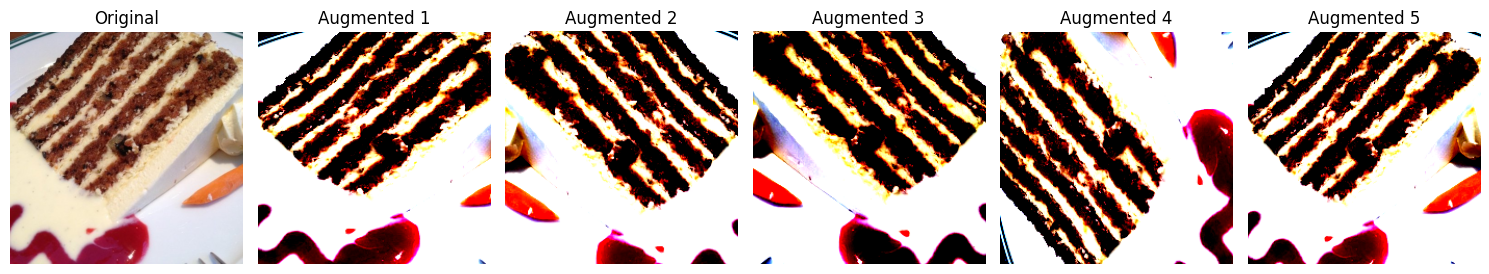

In [73]:
# Visualize sample augmented images
def visualize_augmentations(image_path, num_augmentations=5):
    # Read original image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Create figure
    plt.figure(figsize=(15, 3))
    
    # Show original
    plt.subplot(1, num_augmentations + 1, 1)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off')
    
    # Show augmentations
    for i in range(num_augmentations):
        augmented = train_transform(image=image)
        plt.subplot(1, num_augmentations + 1, i + 2)
        plt.imshow(augmented['image'].permute(1, 2, 0).numpy())
        plt.title(f'Augmented {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show augmentations for a sample image
sample_image = next(iter(dataset_splits['train']))[0]
visualize_augmentations(sample_image)

## Summary of Preprocessing Steps

1. Data Organization:
   - Created train/validation/test splits
   - Organized processed images in separate directories
   
2. Image Processing:
   - Resized all images to 224x224 pixels
   - Applied normalization (ImageNet statistics)
   
3. Data Augmentation (Training):
   - Random resized crop
   - Horizontal flip
   - Brightness/contrast adjustments
   - Random rotation
   
4. Data Pipeline:
   - Created TensorFlow data generators
   - Set up batch processing
   - Implemented categorical encoding for labels
   
Next Steps:
1. Design and implement the model architecture
2. Set up the training pipeline
3. Implement model evaluation metrics